# Introduction


Once we have prepared our starting protein structure and also the forcefield for our CRO residue, we can proceed to constructing the crystal MD system that we can simulate using OpenMM. In OpenMM, to completely specify an MD simulation, we need various components, such the system topology, coordinates, forcefields, and integrator plus various miscellaneous parameters. 

The topology is a description of the type of atoms that consistutes our system, their hierarchical organizations, and the bonds connecting the atoms. In our case, we have atoms from the eGFP protein, waters, and ions, and these atoms are grouped into residues, which then will be grouped into chains according to the specification in the PDB file. The bonds also come from the PDB file, and since we've added CONECT records for the CRO residue, it should have the correct bonds now. Next, the coordinates are simply the Cartesian coordinates for the atoms. The forcefields describes the bonding parameters, as described in the other notebook when we prepared the forcefield for CRO. Finally, the integrator and other parameters determines how we actually implement the equation of motion for the system and whether we want to have additional constraints, such as on system temperature and volume.

Our construction consists of three steps, and since these involve some different background knowledges, we will try to explain them along the way rather in the intro section:
1. Building a complete unit cell of proteins by applying symmetry operators from the P 21 21 21 point group.

2. Neutralize the net charges by adding ions and carefully hydrate the vacuum in the system.

3. Adaptively adjust the amount of bulk water and equilibrate until unit cell volume matches target.

# Step 1. Building a complete unit cell of eGFP proteins

Let's have a crash course in crystallography! What is a crystal? It's a (ideally, infinite) periodic arrangement of atoms in space. By periodic I mean we can translate our crystal pattern by discrete steps in different directions, we will end up with the same pattern. Of course, there are many more symmetry operations that can preserve the exact crystal pattern. To be concrete, a crystallographic symmetry operation is an isometry that stabilizes (in the algebraic sense) the crystal. In the direct space which is Euclidean, the isometries consists of a linear and a translation part, and can express symmetry operations like inversion, rotation, rotoinversion, screw rotation and glide reflection. The collection of such symmetry operations for a crystal pattern is called its space group because it satisfies the (mathematical) group axioms: the operations can be composed associatively, there's an identity operation, and for each operation there's an inverse. Hence, the wonderful machineries from abstract algebra can be applied to classify the infinite many space groups into equivalence classes based on the features of their group structures and it turns out there are finite many (230) types, when not considering chirality. For a more in-depth introduction please refer to International Table of Crystallography, Volume A Part 8 and Volume A1 Part 1.




In our case, the eGFP crystal we used has the $P \ 2_1 \ 2_1 \ 2_1$ space group, with its unit cell schematic shown below:

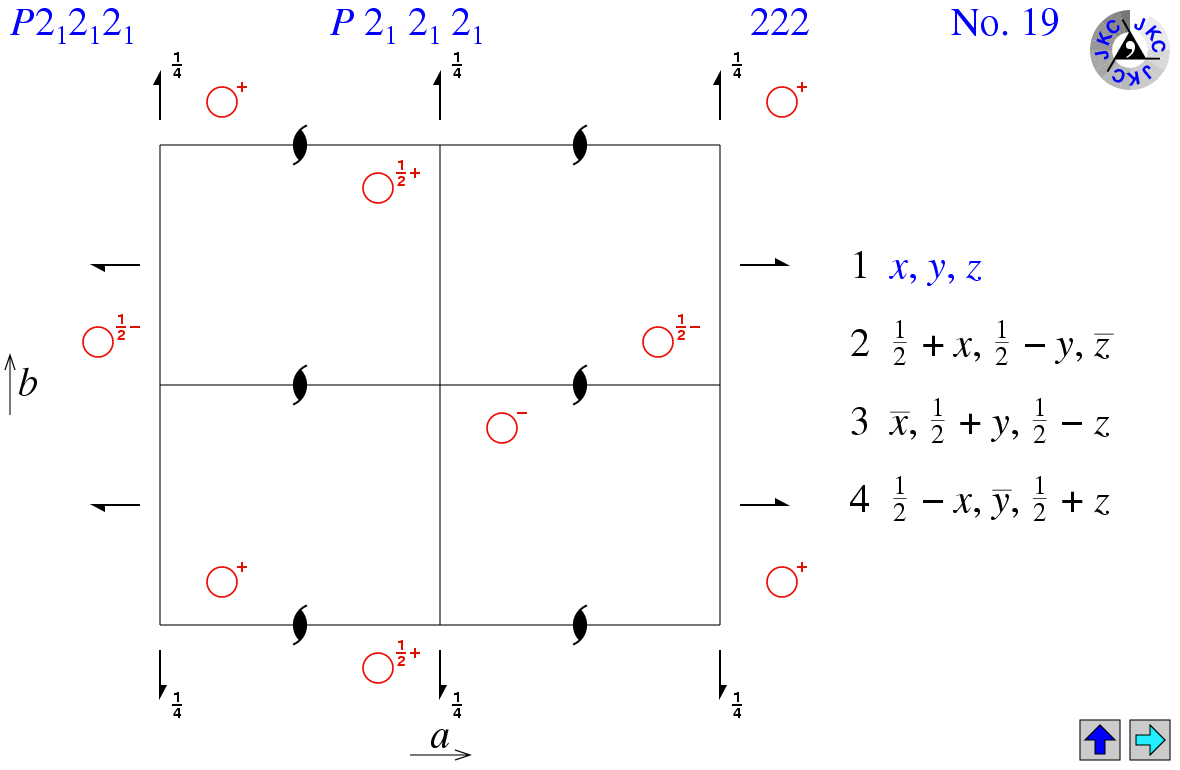



Here we are looking at a tetragonal unit cell with the equal axes $a$ and $b$ at the base. The lattice is of the primitive type (hence the P) in Bravais' classification. There are three screw axes $2_1$, one along each direction, that first rotates by 180 and then shift along the $c$ axis by half of the cell length. One set of screw axes are parallel to the $c$-axis. The other two sets are along $a$ and $b$-axes, with the latter set raised by a half over the base of the unit cell. The empty red circle at lower left indicates either an asymmetric unit, which we can take to be our eGFP monomer, or a single atom from the asymmetric unit. By the application of the three screw axes we can generate (modulo lattice translation) three other equivalent positions in the unit cell, and the fractional coordinate transforms to attain these from the initial position is shown in the numbered list on the right.

To correctly set up an MD simulation with periodic boundary condition (PBC) that is precisely suitable for simulating crystals, we shall first specify the size of our simulation box, which holds a supercell, i.e., a 3D grid of individual unit cells. Here we shall use the most basic setup, which is to simulate just a unit cell, even though this means that, firstly, we could see artefacts such as correlated displacements of neighboring ASUs because of the PBC, and, secondly, we cannot adequately capture the lattice vibrations on a larger scale. However, these are not that problematic for us because, for the first point, we can run many independent simulations to average out the artefacts, and, for the second point, we are not interested in the collective motions of proteins in the lattice but the relative motion of individual atoms in the protein (ASU) subject to oscillating electric fields. 

After deciding the supercell size, we need to construct each unit cell by applying the four symmetry operators for $P \ 2_1 \ 2_1 \ 2_1$ to populate the cell with our eGFP protein. This calculation is not difficult but perhaps just a bit annoying for nonorthogonal coordinate systems. But anyway, we will use Jack Greisman's `mdtools` to do this in one step.

Yet another subtle point to clarify here is that we need to use multiple forcefield files for the system because the inclusion of calcium ion and the CRO residue in our starting structure. With OpenMM, we will define the collection of forcefields before we construct the system. We will use Amber's `ff14SB` forcefield for the protein and its **compatible** water and multivalent ion forcefields `tip3p_standard` and `tip3p_HFE_multivalent`. Finally, we will also include our custom `cro.xml` forcefield file from our previous step. We will not go into a detailed discussion of how to choose these forcefields and verify their compatibility here. (But I might later put in my codes for testing the `HFE_multivalent` and GAFF forcefields with simple diffusion and ion mobility calculations)

In [1]:
from openmm.app import PDBFile, ForceField
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator 
import mdtools

forcefield = ForceField('amber/ff14SB.xml', 
                        'amber/tip3p_standard.xml',
                        'amber/tip3p_HFE_multivalent.xml',
                        '../CRO_parametrization/cro.xml')

# we will use GAFF parameters for acetate
# in my another set of notebook I at least made the effort
# to show that some transport properties calculated from 
# this param. does make sense...
acetate = Molecule.from_smiles('CC(=O)[O-]')
gaff = GAFFTemplateGenerator(molecules=acetate)
forcefield.registerTemplateGenerator(gaff.generator)

egfp = PDBFile("../Protein_structure_preparation/lab_fixed.pdb")
mdsystem = mdtools.LatticeMDSystem(egfp.topology, 
                                   egfp.positions, 
                                   forcefield, "P 21 21 21")
mdsystem.buildSuperCell(1, 1, 1)
mdsystem.save("crystal_vacuum.pdb") 

[[51.533  0.     0.     0.   ]
 [ 0.    62.83   0.     0.   ]
 [ 0.     0.    70.636  0.   ]
 [ 0.     0.     0.     1.   ]]
[[-0.1635]
 [ 2.126 ]
 [-2.119 ]
 [ 1.    ]]
[[-0.00317272]
 [ 0.03383734]
 [-0.02999887]
 [ 1.        ]]
----------------------------
0
original: [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
TTT Matrix:
 [[ 1.     0.     0.    51.533]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.    70.636]
 [ 0.     0.     0.     1.   ]]
pretransmat:
 [0. 0. 0.]
rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
posttransmat:
 [51.533  0.    70.636]
----------------------------
1
original: [[-1.0, 0.0, 0.0, 0.5], [0.0, -1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.5], [0.0, 0.0, 0.0, 1.0]]
TTT Matrix:
 [[-1.      0.      0.     25.7665]
 [ 0.     -1.      0.     62.83  ]
 [ 0.      0.      1.     35.318 ]
 [ 0.      0.      0.      1.    ]]
pretransmat:
 [0. 0. 0.]
rotation:
 [[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
posttransmat:
 [25.766

# 2. Neutralize the net charges and add waters carefully

After this step, we will get our unit cell simulation system filled with four copies of eGFP. Some of the empty region in our unit cell is actually filled by other copies of eGFP from neighboring unit cells assumed by the PBC, but these mirror copies will not be displayed by softwares like pymol. But there is still much vacuum in between the solvation shells of the eGFP copies within a single unit cell that we need to fill with water to ensure a stable simulation. Naively, we might propose just randomly adding waters to the simulation box. But then we may not get the density right, so the simulation box will shrink once we simulate the system as from NPT ensemble.

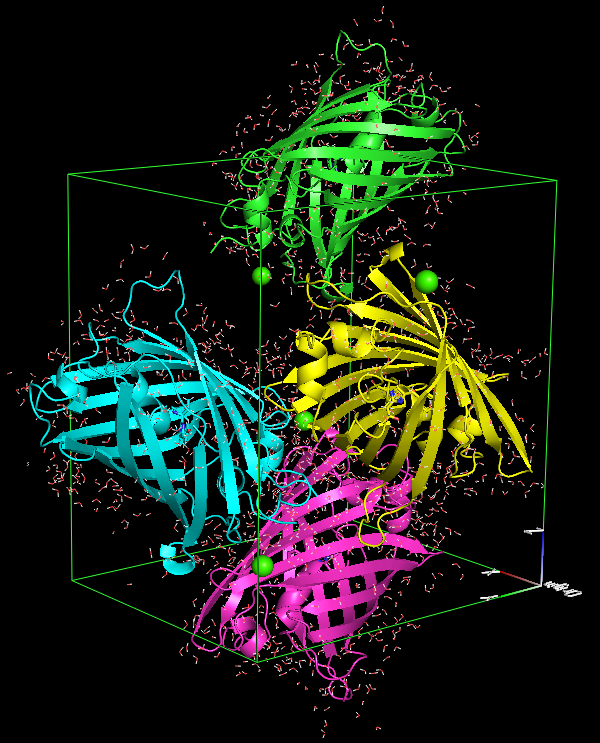

The solution is that we will first rely on OpenMM's utility function provided through the Modeller class to hydrate the voids in the simulation box and add appropriate ions to neutralize the charge. Then we will add more waters. The way we do this is to use `duplicateWaters` which copies existing waters and jitter them a bit to prevent force overflow later. 

Then for the ions, since OpenMM does not support adding multivalent or organic ions, we will add monovalent ions like Ca2+ and Cl- first and then replace them with our desired ions later. In our case the crystal is experimentally prepared in a solution with nominal concentrations of $0.15$M for NaCl and $0.2$M for Ca(OAc)2. Now at our unit cell volume of around $210nm^3$, every $0.1$M corresponds to $12.6$ molecules at 100% solvent fraction. However, empirically the crystal has about 1/3 solvent fraction. So we decide on 6 NaCl and 8 Ca(OAc)2. We already have 4 structural Ca2+ in the system and -20 net charge from four eGFPs, so we will add 6 Na+, 4 Ca2+ (upon the existing 4 Ca2+) and  2 OAc- to neutralize. We will replace some of the waters OpenMM added with the ions.




In [2]:
print("Net charge per eGFP protein: ", round(sum(mdsystem.getCharges('chainid==0'))))

mdsystem.addSolvent(neutralize=False)
mdsystem.save("solvated.pdb")


Net charge per eGFP protein:  -5


At this point it's a good idea to check that the newly added waters are beyond the hydration shell and not inside the eGFP! The visualization from pymol assured me of this. (Although I do have a separate script for tagging waters from cavities)

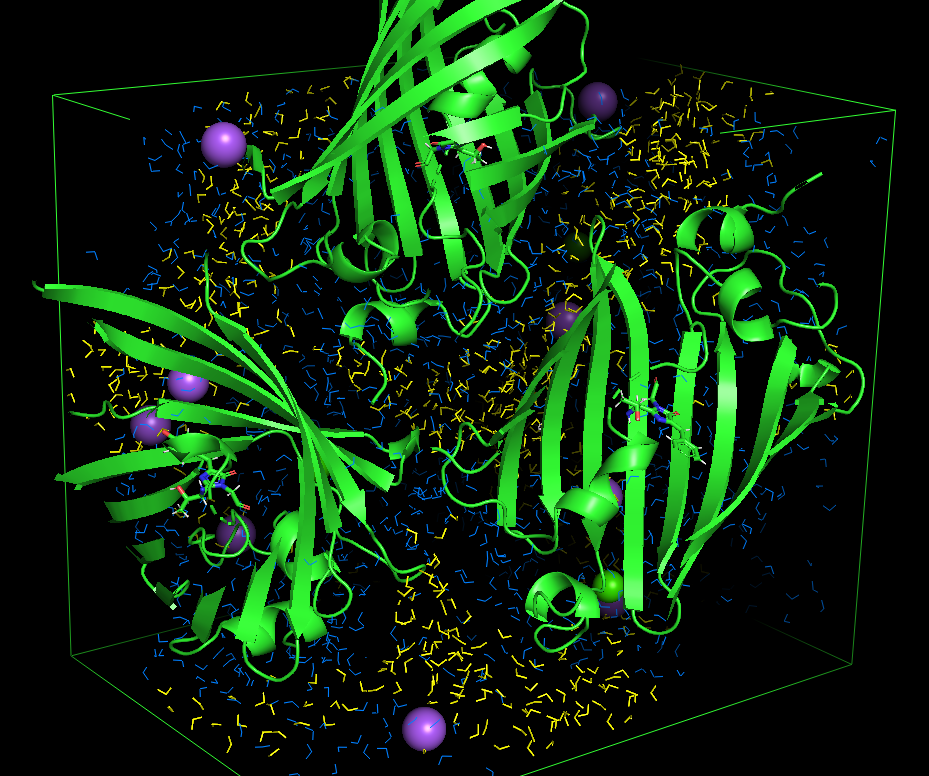
Figure 3. A visualization of the (preliminary) solvated unit cell, where the yellow sticks are newly added waters and the blue sticks are waters from the prepared starting structure.

For the lack of good tools to do the small molecule replacement task via a Python API, I resorted to using MOE (not pretty, not at all) for manual replacement. I have built a lightweight chem editor tool based on Open Force Field Toolkit's API that could help automate this step. I should come back later and update my notebook once I release the tool.

My edited file is called `neutralized.pdb`. We now check that it's charge neutralized by adding the number of sodium, calcium, and acetate ions calculated above. 

In [3]:
neutralized = PDBFile("../Crystal_system_construction/neutralized.pdb")
mdsystem = mdtools.LatticeMDSystem(neutralized.topology, 
                                   neutralized.positions, 
                                   forcefield, "P 1")

print("Net charge of entire system:", 
      sum([round(sum(mdsystem.getCharges(f'chainid=={i}'))) for i in range(mdsystem.topology.getNumChains())]))


Net charge of entire system: 0


# Step 3. Adjust the amount of bulk water and equilibrate

Now we can proceed to the equilibration steps. The goal is to adjust our system so its dynamics will roughly approximate the ensemble behavior that corresponds to the physical conditions of interest. For example, we often talk about thermal equilibration of MD systems, i.e., coupling them to thermal baths and heating up to the experimental temperature and running the simulation for some time. 

Here, the first step is to make sure the unit cell volume (and hence bulk density) matches experimental measurements, i.e., the initial lattice vectors determined from crystallography. We will use Jack Greisman's code for doing this. The equilibration is necessary because we tried to be on the safe side when solvating our system, and once the simulation is started at fixed volume, the bulk solvent will have a higher density, i.e., we must add more water to maintain the system volume. So the idea of the algorithm is that we will start from a copy of our MD system, dump in waters, and then carefully equilibrate in multiple stages (details omitted here), eventually checking if the average and fluctuation in system volume is within a set range of the target volume. We will adjust the amount of water added accordingly to achieve this over many iterations.

The script below is intended to be run on a HPC using GPU nodes. I did this on FASRC platform, loading modules `cuda/11.1.0-fasrc01` and `cudnn/8.1.0.77_cuda11.2-fasrc01` that are compatible with my OpenMM version to facilitate using CUDA-suppported GPU programming for accelerating MD simulation. 

In [4]:
with open('./squeeze_run.py', 'r') as f:
    print(f.read())

# import stuff
from openmm.app import PDBFile, ForceField
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator
from simtk.unit import *
import mdtraj
import mdtools
import pickle 


# initialize forcefield
# need to have openmmforcefields installed first
forcefield = ForceField('amber/ff14SB.xml', 
                        'amber/tip3p_standard.xml',
                        'amber/tip3p_HFE_multivalent.xml',
                        '../CRO_parametrization/cro.xml')
acetate = Molecule.from_smiles('CC(=O)[O-]')
gaff = GAFFTemplateGenerator(molecules=acetate)
forcefield.registerTemplateGenerator(gaff.generator)

# load the crystal system
crystal = PDBFile("neutralized.pdb")
mdsystem = mdtools.LatticeMDSystem(crystal.topology,
                                   crystal.positions, 
                                   forcefield, "P 21 21 21")

mdsystem.buildSimulation()
print("System initialized for squeezing. Currently running on platfor

I also provided the job script to provide a template as to the job parameters I determined previously for this step.

In [5]:
with open('./squeeze_run.sh', 'r') as f:
    print(f.read())

#!/bin/bash
#SBATCH --gres=gpu:1
#SBATCH -t 0-08:00          # Runtime in D-HH:MM, minimum of 10 minutes
#SBATCH -p gpu
#SBATCH --mem=64G           # Memory pool for all cores (see also --mem-per-cpu)
#SBATCH -o squeeze_gpu_%A_%a.out
#SBATCH -e squeeze_gpu_%A_%a.err

source $LOGIN/.bashrc
source $LOGIN/.bash_addons 
conda activate openmm
PENMM_DEFAULT_PLATFORM=CUDA
python squeeze_run.py




Then in my case I will see a log like this:

```
System initialized for squeezing. Currently running on platform  CUDA
Initial perturbation +1160 waters
Case 1: Too far from convergence
Percent Change: 0.008663963390880483 +/- 0.0001363739368360303
Reverted atom positions and box vectors
+39.0 waters
Case 1: Too far from convergence
Percent Change: 0.004097341903551353 +/- 0.00011618725212822714
Reverted atom positions and box vectors
+18.0 waters
Case 1: Too far from convergence
Percent Change: 0.0017627588304880003 +/- 0.00011351883185120381
Reverted atom positions and box vectors
+8.0 waters
Case 2: converged
Percent Change: -4.479315403791025e-05 +/- 3.0116786035422753e-05
```

which means that despite my earlier knowledge that around 1160 waters should be added, the program determines to add some more water molecules to reach the target volume.

Finally, we can visualize the volume trajectories for these iterations and see how that stabilized as we add more waters with `plot_squeeze_run.py`. The files are large so it's preferable to do this on the HPC platform, with just the command `python plot_squeeze_run.py` (which uses all default arguments to detect the files) at command line. The resulting plot will look like:

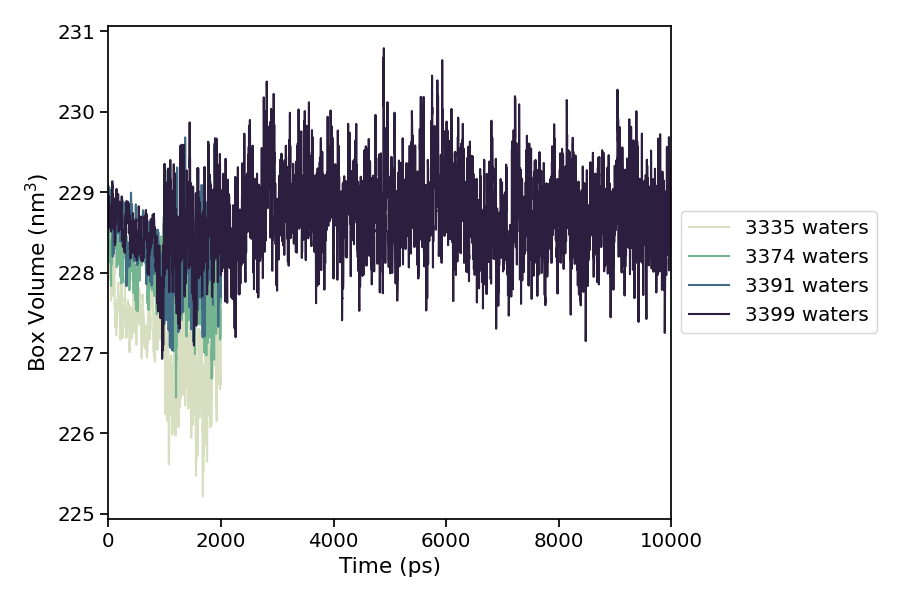


Let me clarify the visualization here. The volume equilibration (squeeze) protocol used first energy minimize and then equilibrate the system in NPT ensemble (which is why the volume fluctuates) but with restraints on heavy, nonsolvent atoms. The restraints are completely tapered off at 2ns mark, where the system volume will be computed. If too far from target the amount of water will be adjusted and a new equilibration would be restarted from the initial configuration. Otherwise, we do more NPT simulation until hitting the 10ns mark, and then calculate the average and spread in system volume. In the last iteration (dark purple) we see that the volume finally stabilized around our target volume.